# Importing Libraries

In [1]:
# Standard Libraries
import math
import itertools
from collections import Counter
from itertools import combinations

# Data Handling
import pandas as pd
import numpy as np

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm 
from matplotlib.colors import from_levels_and_colors
from IPython.display import display
%matplotlib inline

# Statistical Libraries
import scipy.stats as stats
from scipy.stats import ttest_ind, f_oneway, chi2_contingency, chi2
from scipy.stats import multivariate_normal
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Turn Off Warnings
import warnings
warnings.filterwarnings('ignore')

# Statistical Modeling

In [2]:
# Load cleaned dataset
churn_df = pd.read_csv('/Users/williamjowens/Desktop/Datasets/clean_df.csv')
churn_df.head()

,call_failures,complaint,months_subscribed,charge_amt,total_call_secs,total_calls,total_texts,distinct_calls,age_group,tariff_plan,active_status,customer_value,churn
0,8,0,38,0,4370,71,5,17,3,0,1,197.640,0
1,0,0,39,0,318,5,7,4,2,0,0,46.035,0
2,10,0,37,0,2453,60,359,24,3,0,1,1536.520,0
3,10,0,38,0,4198,66,1,35,1,0,1,240.020,0
4,3,0,38,0,2393,58,2,33,1,0,1,145.805,0


## Initial Model

In [3]:
# Define variables
X = churn_df.drop(columns=['churn'])
y = churn_df['churn']

# Add constant
X = sm.add_constant(X)

# Run logistic regression
logit_mod = sm.GLM(y, X, family=sm.families.Binomial())
logit_mod = logit_mod.fit()

# Get summary
summary = logit_mod.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                 3150
Model:                            GLM   Df Residuals:                     3137
Model Family:                Binomial   Df Model:                           12
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -692.56
Date:                Tue, 31 Oct 2023   Deviance:                       1385.1
Time:                        08:54:22   Pearson chi2:                 2.13e+03
No. Iterations:                     8   Pseudo R-squ. (CS):             0.3495
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.4205      0.429      0.980      0.327      -0.420       1.261
call_failures         0.1314      0.018      7.394      0.000       0.097       0.166
complaint             4.0423      0.282     14.320      0.000       3.489       4.596
months_subscribed    -0.0299      0.010     -3.149      0.002      -0.049      -0.011
charge_amt           -0.4154      0.121     -3.448      0.001      -0.652      -0.179
total_call_secs       0.0001      0.000      0.790      0.429      -0.000       0.000
total_calls          -0.0553      0.008     -6.518      0.000      -0.072      -0.039
total_texts          -0.0468      0.012     -3.848      0.000      -0.071      -0.023
distinct_calls       -0.0111      0.010     -1.150      0.250      -0.030       0.008
age_group             0.1196      0.111      1.077      0.281      -0.098       0.337
tariff_plan           0.2399      0.629      0.381      0.703      -0.993       1.473
active_status        -1.4087      0.201     -7.013      0.000      -1.802      -1.015
customer_value        0.0082      0.003      2.922      0.003       0.003       0.014
=====================================================================================
"""

In [4]:
# Odds ratios and OR confidence intervals function
def odds_ratios(fitted_model):
    """
    Calculate the odds ratios and 95% confidence intervals from a fitted model.

    Returns: A DataFrame containing the odds ratios and their 95% confidence intervals.
    """
    # Extracting the coefficients and the confidence intervals
    params = fitted_model.params[1:]  # exclude intercept
    conf_int = fitted_model.conf_int().iloc[1:]  # exclude intercept
    
    # Calculating the odds ratios and their 95% CIs
    odds_ratios = np.exp(params)
    ci_lower = np.exp(conf_int.iloc[:, 0])
    ci_upper = np.exp(conf_int.iloc[:, 1])

    # Combining results in a DataFrame for better visualization
    results = pd.DataFrame({
        'Coefficient': params,
        'Odds Ratio': odds_ratios,
        '95% CI Lower': ci_lower,
        '95% CI Upper': ci_upper
    })
    
    return results

In [5]:
# Call the function
OR_initial = odds_ratios(logit_mod)
OR_initial

,Coefficient,Odds Ratio,95% CI Lower,95% CI Upper
call_failures,0.131359,1.140377,1.101350,1.180786
complaint,4.042349,56.959961,32.756143,99.048207
months_subscribed,-0.029941,0.970503,0.952586,0.988758
charge_amt,-0.415432,0.660055,0.521206,0.835893
total_call_secs,0.000112,1.000112,0.999834,1.000390
total_calls,-0.055299,0.946202,0.930599,0.962067
total_texts,-0.046795,0.954283,0.931807,0.977301
distinct_calls,-0.011076,0.988985,0.970496,1.007826
age_group,0.119607,1.127054,0.906618,1.401088
tariff_plan,0.239905,1.271129,0.370323,4.363130


In [6]:
# Goodness of fit statistics function
from scipy.stats import chi2

def gof_stats(fitted_model):
    """
    Returns a DataFrame containing the AIC, BIC, and Deviance.
    """
    aic = fitted_model.aic
    bic = fitted_model.bic_llf
    deviance = fitted_model.deviance
    df = fitted_model.df_resid
    p_value = chi2.sf(deviance, df)
    
    gof_df = pd.DataFrame({
        'Statistic': ['AIC', 'BIC', 'Deviance', 'p-value (Dev)'],
        'Value': [aic, bic, deviance, p_value]
    })
    
    return gof_df

In [7]:
# Call the function
gof_initial = gof_stats(logit_mod)
gof_initial

,Statistic,Value
0,AIC,1411.126529
1,BIC,1489.843580
2,Deviance,1385.126529
3,p-value (Dev),1.000000


In [8]:
# Hosmer-Lemeshow Test function
def hosmer_lemeshow_test(y_true, y_pred_prob):
    """
    Perform the Hosmer-Lemeshow goodness of fit test.

    Returns: A DataFrame containing the Hosmer-Lemeshow test statistic and p-value.
    """
    # Convert y_true and y_pred_prob to pandas Series
    y_true = pd.DataFrame(y_true).squeeze()
    y_pred_prob = pd.Series(y_pred_prob)

    # Error handling
    if len(y_true) != len(y_pred_prob):
        raise ValueError("y_true and y_pred_prob must be of the same length.")

    # Group data into deciles
    n_deciles = 10
    try:
        groups = pd.qcut(y_pred_prob, q=n_deciles, duplicates='drop')
    except ValueError as e:
        raise ValueError("Error grouping data into deciles.") from e

    # Calculate the observed events and non-events in each group
    obs_events = y_true.groupby(groups).sum()
    obs_non_events = y_true.groupby(groups).count() - obs_events

    # Calculate the expected events and non-events in each group
    exp_events = y_pred_prob.groupby(groups).sum()
    exp_non_events = (1 - y_pred_prob).groupby(groups).sum()

    # Calculate the Hosmer-Lemeshow statistic
    H = np.sum((obs_events - exp_events) ** 2 / exp_events +
               (obs_non_events - exp_non_events) ** 2 / exp_non_events)

    # Degrees of freedom is number of groups - 2
    df = len(groups.cat.categories) - 2

    # p-value
    p_value = chi2.sf(H, df=df)

    # Creating DataFrame for the results
    result_df = pd.DataFrame({
        'Statistic': ['Hosmer-Lemeshow Test H', 'Degrees of Freedom', 'p-value'],
        'Value': [H, df, p_value]
    })

    return result_df

In [9]:
# Predicted probabilities
y_pred_prob = logit_mod.predict()

# HL Test
HL_results = hosmer_lemeshow_test(y, y_pred_prob)
HL_results

,Statistic,Value
0,Hosmer-Lemeshow Test H,22.904712
1,Degrees of Freedom,8.000000
2,p-value,0.003489


In [10]:
# Check multicollinearity
def calculate_vif(df):
    """
    Calculate the VIF for each variable in the DataFrame.

    Returns: A DataFrame containing the variables and their corresponding VIF score.
    """
    # Initialize a DataFrame to store the VIF data
    vif_data = pd.DataFrame()
    vif_data["variable"] = df.columns
    
    # Calculate VIF for each variable
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
    
    # Sort the DataFrame by VIF in descending order
    vif_data = vif_data.sort_values(by=['VIF'], ascending=False)
    
    return vif_data

In [11]:
# Call the function
selected_features = X.drop(columns='const').columns
vif_info = calculate_vif(X[selected_features])
vif_info

,variable,VIF
11,customer_value,83.195806
6,total_texts,50.934524
5,total_calls,46.342451
4,total_call_secs,45.470945
8,age_group,12.463875
2,months_subscribed,11.202536
7,distinct_calls,6.873198
10,active_status,6.219737
0,call_failures,5.987179
3,charge_amt,4.133866


## Reduced Model

In [12]:
# Backward elimination function
def backward_elimination(X, y):
    """
    Perform backward elimination on a logit model.

    Returns: The reduced model and a DataFrame with the selected predictors.
    """
    predictors = list(X.columns)
    while len(predictors) > 0:
        X_temp = X[predictors]
        model = sm.GLM(y, X_temp, family=sm.families.Binomial()).fit()
        p_values = model.pvalues.iloc[1:]  # excluding the intercept
        pmax = max(p_values)
        feature_with_p_max = p_values.idxmax()
        if pmax > 0.05:
            predictors.remove(feature_with_p_max)
        else:
            break
    return model, X_temp

In [13]:
# Call the function
reduced_mod, X_selected = backward_elimination(X, y)
reduced_summary = reduced_mod.summary()
reduced_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                 3150
Model:                            GLM   Df Residuals:                     3141
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -694.94
Date:                Tue, 31 Oct 2023   Deviance:                       1389.9
Time:                        08:54:22   Pearson chi2:                 2.15e+03
No. Iterations:                     8   Pseudo R-squ. (CS):             0.3486
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.7238      0.331      2.188      0.029       0.075       1.372
call_failures         0.1216      0.016      7.378      0.000       0.089       0.154
complaint             4.0549      0.281     14.423      0.000       3.504       4.606
months_subscribed    -0.0295      0.009     -3.142      0.002      -0.048      -0.011
charge_amt           -0.3242      0.094     -3.459      0.001      -0.508      -0.140
total_calls          -0.0523      0.006     -8.168      0.000      -0.065      -0.040
total_texts          -0.0474      0.008     -5.994      0.000      -0.063      -0.032
active_status        -1.4324      0.199     -7.212      0.000      -1.822      -1.043
customer_value        0.0084      0.002      4.683      0.000       0.005       0.012
=====================================================================================
"""

In [14]:
# Odds ratios
OR_reduced = odds_ratios(reduced_mod)
OR_reduced

,Coefficient,Odds Ratio,95% CI Lower,95% CI Upper
call_failures,0.121572,1.129271,1.093382,1.166338
complaint,4.054904,57.679650,33.243871,100.076854
months_subscribed,-0.029518,0.970913,0.953199,0.988956
charge_amt,-0.324179,0.723121,0.601776,0.868934
total_calls,-0.052313,0.949032,0.937193,0.961020
total_texts,-0.047389,0.953716,0.939052,0.968609
active_status,-1.432383,0.238739,0.161760,0.352352
customer_value,0.008387,1.008423,1.004889,1.011969


In [15]:
# Goodness of fit statistics
gof_reduced = gof_stats(reduced_mod)
gof_reduced

,Statistic,Value
0,AIC,1407.870918
1,BIC,1462.367338
2,Deviance,1389.870918
3,p-value (Dev),1.000000


In [16]:
# Predicted probabilities
y_pred_prob = reduced_mod.predict()

# HL Test
HL_results = hosmer_lemeshow_test(y, y_pred_prob)
HL_results

,Statistic,Value
0,Hosmer-Lemeshow Test H,28.742728
1,Degrees of Freedom,8.000000
2,p-value,0.000352


In [17]:
# Call the function
selected_features = X_selected.drop(columns='const').columns
vif_info = calculate_vif(X_selected[selected_features])
vif_info

,variable,VIF
7,customer_value,39.794347
5,total_texts,26.089677
4,total_calls,11.285861
6,active_status,5.170407
0,call_failures,5.097420
2,months_subscribed,4.173426
3,charge_amt,2.434918
1,complaint,1.190960


## Residual Plots

In [18]:
# Function to plot deviance residuals
def plot_deviance_residuals(fitted_model, figsize=(15, 7)):
    """
    Plots the deviance residuals against fitted values for a logistic regression model.
    """
    # Generate the fitted values
    fitted_values = fitted_model.fittedvalues

    # Calculate the deviance residuals
    deviance_residuals = fitted_model.resid_deviance

    # Create the plot
    plt.figure(figsize=figsize)
    sns.regplot(x=fitted_values, y=deviance_residuals, color="black",
                scatter_kws={"s": 5}, line_kws={"color": "b", "alpha": 1, "lw": 2},
                lowess=True)
    plt.title("Deviance Residuals vs. Fitted Values")
    plt.xlabel("Linear Predictor Values")
    plt.ylabel("Deviance Residuals")
    plt.show()

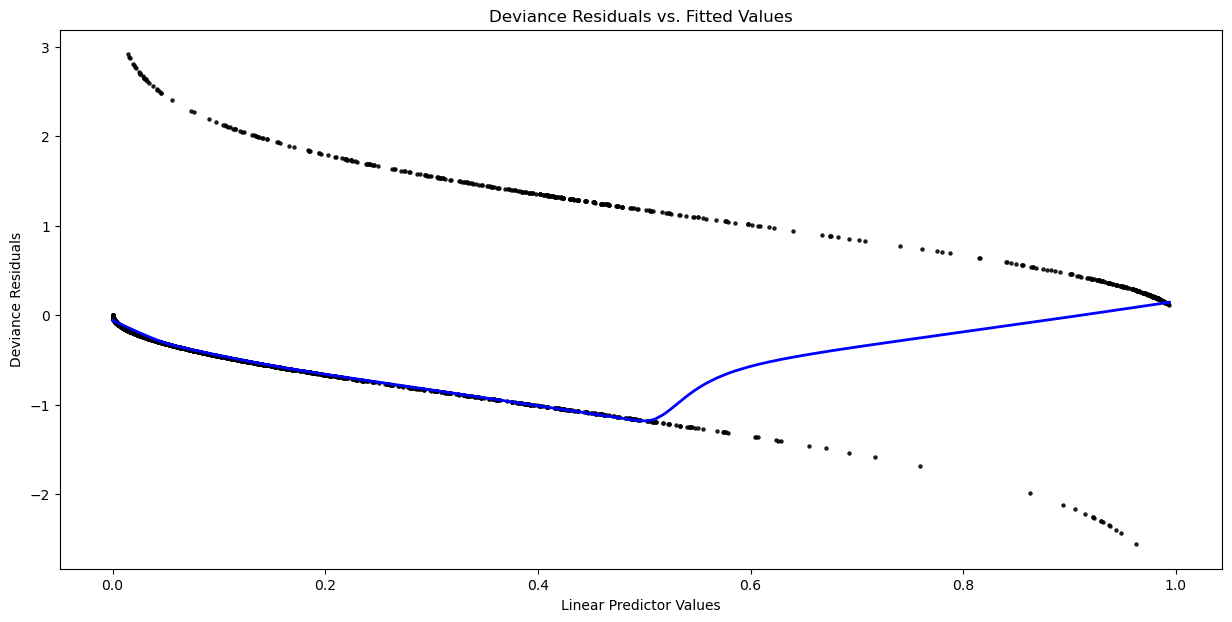

In [19]:
# Call the function
plot_deviance_residuals(reduced_mod)

In [20]:
# Function to plot studentized Pearson residuals
def plot_pearson_residuals(fitted_model, figsize=(15, 7)):
    """
    Plots the studentized Pearson residuals against fitted values for a logistic regression model.
    """
    # Generate the fitted values
    fitted_values = fitted_model.fittedvalues

    # Calculate the Pearson residuals
    pearson_residuals = fitted_model.resid_pearson

    # Create the plot
    plt.figure(figsize=figsize)
    sns.regplot(x=fitted_values, y=pearson_residuals, color="black",
                scatter_kws={"s": 5}, line_kws={"color": "g", "alpha": 1, "lw": 2},
                lowess=True)
    plt.title("Studentized Pearson Residuals vs. Fitted Values")
    plt.xlabel("Linear Predictor Values")
    plt.ylabel("Studentized Pearson Residuals")
    plt.show()

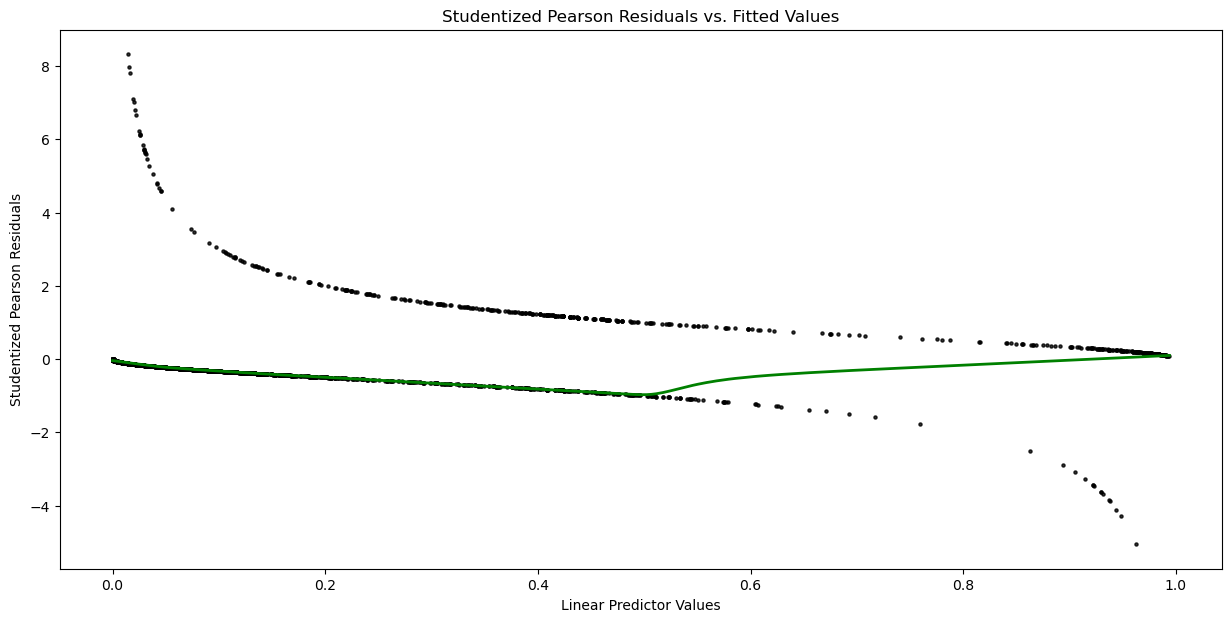

In [21]:
# Call the function
plot_pearson_residuals(reduced_mod)

## Interacted Model

In [22]:
X_selected.head()

,const,call_failures,complaint,months_subscribed,charge_amt,total_calls,total_texts,active_status,customer_value
0,1.0,8,0,38,0,71,5,1,197.640
1,1.0,0,0,39,0,5,7,0,46.035
2,1.0,10,0,37,0,60,359,1,1536.520
3,1.0,10,0,38,0,66,1,1,240.020
4,1.0,3,0,38,0,58,2,1,145.805


In [23]:
# Define variables
X_selected['complaint:active_status'] = X_selected['complaint'] * X_selected['active_status']
y = churn_df['churn']

# Run logistic regression
interact_mod = sm.GLM(y, X_selected, family=sm.families.Binomial())
interact_mod = interact_mod.fit()

# Get summary
summary = interact_mod.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                 3150
Model:                            GLM   Df Residuals:                     3140
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -682.17
Date:                Tue, 31 Oct 2023   Deviance:                       1364.3
Time:                        08:54:23   Pearson chi2:                 2.25e+03
No. Iterations:                     8   Pseudo R-squ. (CS):             0.3538
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.6454      0.350      1.845      0.065      -0.040       1.331
call_failures               0.1280      0.017      7.679      0.000       0.095       0.161
complaint                   2.9935      0.298     10.050      0.000       2.410       3.577
months_subscribed          -0.0256      0.010     -2.569      0.010      -0.045      -0.006
charge_amt                 -0.4881      0.109     -4.470      0.000      -0.702      -0.274
total_calls                -0.0504      0.006     -7.778      0.000      -0.063      -0.038
total_texts                -0.0422      0.008     -5.378      0.000      -0.058      -0.027
active_status              -1.4500      0.204     -7.124      0.000      -1.849      -1.051
customer_value              0.0069      0.002      3.806      0.000       0.003       0.011
complaint:active_status     2.7612      0.583      4.737      0.000       1.619       3.904
===========================================================================================
"""

In [24]:
# Odds ratios
OR_interact = odds_ratios(interact_mod)
OR_interact

,Coefficient,Odds Ratio,95% CI Lower,95% CI Upper
call_failures,0.128034,1.136592,1.100048,1.174351
complaint,2.993471,19.954826,11.130214,35.776050
months_subscribed,-0.025611,0.974714,0.955855,0.993946
charge_amt,-0.488091,0.613797,0.495538,0.760279
total_calls,-0.050362,0.950885,0.938894,0.963030
total_texts,-0.042214,0.958665,0.944028,0.973528
active_status,-1.449976,0.234576,0.157415,0.349560
customer_value,0.006947,1.006972,1.003375,1.010581
complaint:active_status,2.761162,15.818219,5.046324,49.583826


In [25]:
# Goodness of fit statistics
gof_interact = gof_stats(interact_mod)
gof_interact

,Statistic,Value
0,AIC,1384.345561
1,BIC,1444.897138
2,Deviance,1364.345561
3,p-value (Dev),1.000000


In [26]:
# Predicted probabilities
y_pred_prob = interact_mod.predict()

# HL Test
HL_results = hosmer_lemeshow_test(y, y_pred_prob)
HL_results

,Statistic,Value
0,Hosmer-Lemeshow Test H,12.490907
1,Degrees of Freedom,8.000000
2,p-value,0.130608


In [27]:
# Check multicollinearity
selected_features = X_selected.drop(columns='const').columns
vif_info = calculate_vif(X_selected[selected_features])
vif_info

,variable,VIF
7,customer_value,39.887448
5,total_texts,26.185168
4,total_calls,11.306887
6,active_status,5.528965
0,call_failures,5.138572
2,months_subscribed,4.395839
3,charge_amt,2.498476
1,complaint,1.972488
8,complaint:active_status,1.770423


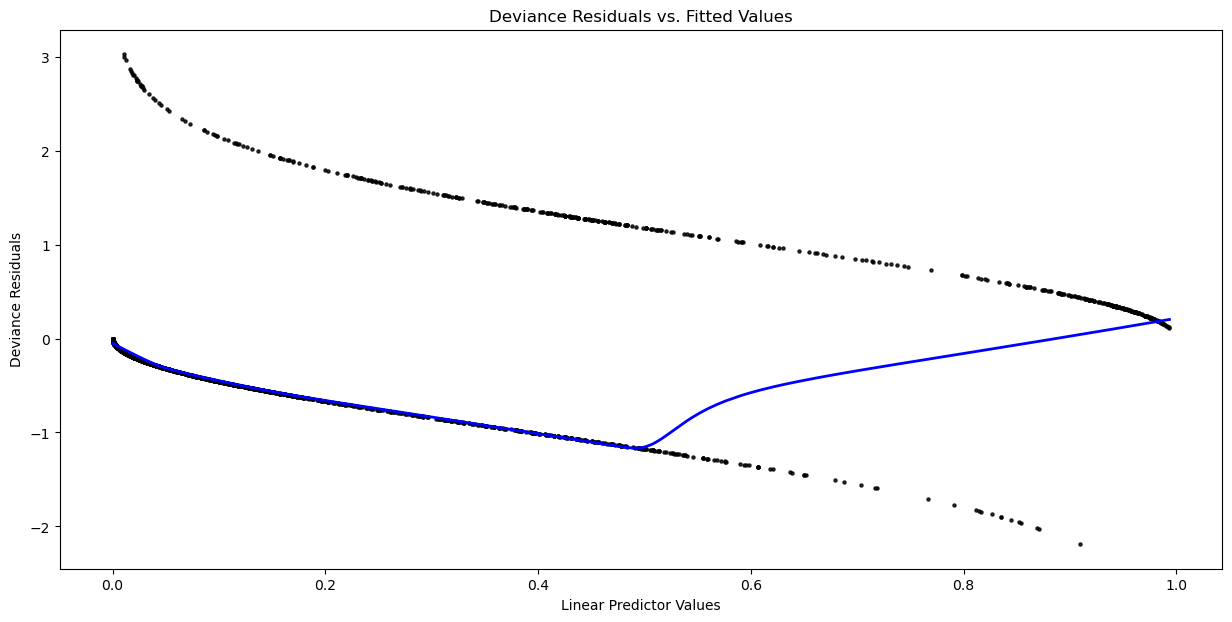

In [28]:
# Plot deviance residuals
plot_deviance_residuals(interact_mod)

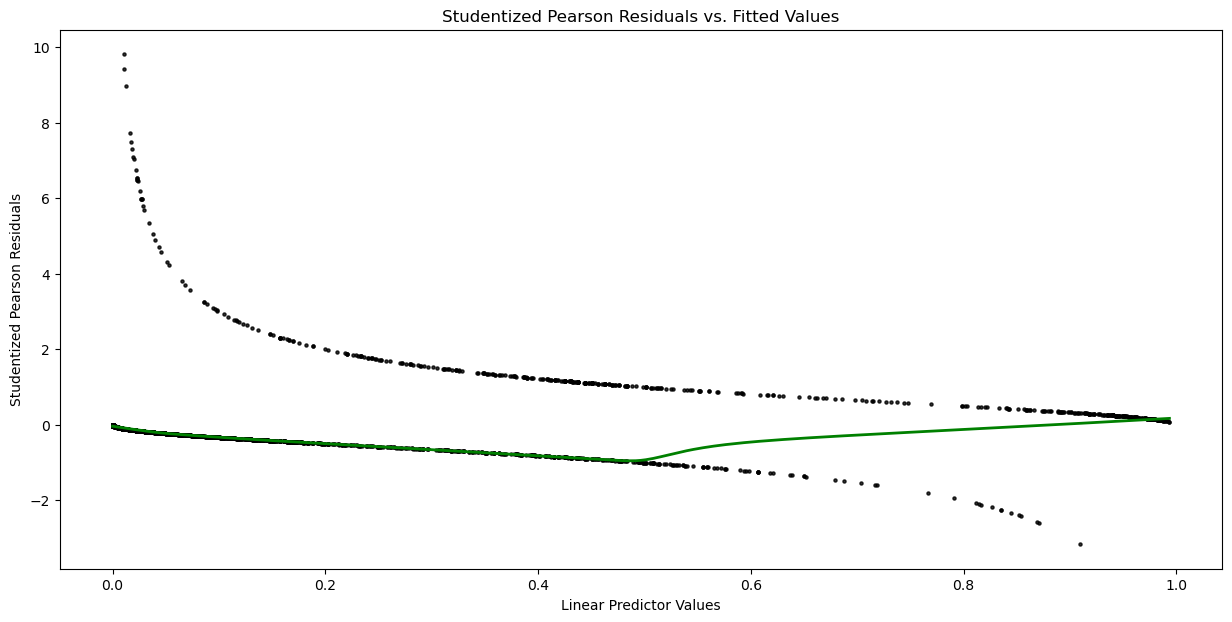

In [29]:
# Plot studentized Pearson residuals
plot_pearson_residuals(interact_mod)